# UBC Lost & Found Predictive Analysis

<img src="./img/access.jpg" alt="drawing" style="width:90%;"/>
Access Services. Retrieved from <a href = "https://parking.ubc.ca/">UBC Parking</a> 

## Introduction 
---

Losing personal belongings is a common and often frustrating experience for students and staff at UBC. Items ranging from everyday essentials like wallets and keys to electronics and jewelry frequently end up in the lost and found. While the university maintains a central lost and found system, the lack of systematic analysis in these services can lead to inefficiencies, making it harder to identify trends and optimize recovery processes. By analyzing the UBC lost and found dataset, this project aims to uncover patterns in lost items, predict future trends, and provide actionable insights to enhance the efficiency of UBC's lost and found services.

**Objectives**: 
- **Item Classification Analysis**: Identify the most frequently lost item categories (e.g., electronics, wallets, keys).
- **Temporal Analysis**: Examine seasonal and daily trends in lost item reports.
- **Location Analysis**: Identify the most common campus locations where items are lost and found.
- **Item Description Analysis**: Group similar items based on "Item Description" to identify detailed subcategories of lost items using NLP techniques
- **Time Series Forecasting**: Develop predictive models to forecast the number of items reported to the lost and found using historical data.
- **Recommendations**: Provide actionable recommendations to improve the lost and found system, including targeted awareness campaigns, optimized item storage, and enhanced communication channels.


## Dataset
---

The [UBC Lost and Found database](https://lostandfound.ubc.ca/all-items) is a publicly accessible dataset containing information about items reported lost within the University of British Columbia campus. The dataset spans from May 2024 to the current day, with over 160 entries. Each entry includes details such as the item type, description, date lost, and location. We will be using the dataset retrieved as of February 2025 for the project.

### Loading libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mglearn
import spacy
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

### Importing the data

In [2]:
url = "https://lostandfound.ubc.ca/all-items/export.csv"
df = pd.read_csv(url, index_col = "Date")

df.head()

,Ticket Number,Item Type,Status,Item Description,Lost Item Location
Date,,,,,
"February 21, 2025",47231,Phone,Lost,phone,Pedestrian Area
"February 21, 2025",47230,Wallet,Lost,Brown Cardholder,NaN
"February 20, 2025",47229,Electronics,Lost,Car Fob,NaN
"February 19, 2025",47228,Jewelry,Lost,Watch,NaN
"February 19, 2025",47227,Keys,Lost,Single Key,NaN


## Data Wrangling & Cleaning
---

### Examining the data

We begin by exploring the dataset to understand its structure.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, February 21, 2025 to May 31, 2024
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Ticket Number       193 non-null    int64 
 1   Item Type           193 non-null    object
 2   Status              189 non-null    object
 3   Item Description    193 non-null    object
 4   Lost Item Location  136 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.0+ KB


In [4]:
df.describe(include = "all")

,Ticket Number,Item Type,Status,Item Description,Lost Item Location
count,193.000000,193,189,193,136
unique,NaN,7,1,166,4
top,NaN,Electronics,Lost,phone,Other
freq,NaN,76,189,4,108
mean,47093.186528,NaN,NaN,NaN,NaN
std,84.996976,NaN,NaN,NaN,NaN
min,46923.000000,NaN,NaN,NaN,NaN
25%,47020.000000,NaN,NaN,NaN,NaN
50%,47089.000000,NaN,NaN,NaN,NaN
75%,47169.000000,NaN,NaN,NaN,NaN


### Handling missing values

In [5]:
df.isna().sum()

Ticket Number          0
Item Type              0
Status                 4
Item Description       0
Lost Item Location    57
dtype: int64

- For the `Lost Item Location` column, missing values will be replaced with "`Unknown`" to ensure data completeness.
- Missing values in the `Status` column are minimal (4 rows) and will not be addressed as they have no impact on analysis.

In [6]:
value = {"Lost Item Location": "Unknown"}
df.fillna(value=value, inplace=True)

### Datetime Conversion

To facilitate temporal analysis, the `Date` index is converted to a proper datetime object. Additional features like `Year`, `Month`, and `Weekday` are also extracted.

In [7]:
df.index = pd.to_datetime(df.index)
df['Year'] = df.index.year
df['Month'] = df.index.month_name()
df['Weekday'] = df.index.day_name()

### Cleaning the data

To finalize the data preparation, we will check for any duplicated values and ensure chronological consistency by sorting the dataset by date.

In [8]:
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0


In [9]:
df = df.sort_values('Date', ascending=True)

After cleaning, the dataset is sorted by date. Below is a preview of the first five rows:

In [10]:
df.head()

,Ticket Number,Item Type,Status,Item Description,Lost Item Location,Year,Month,Weekday
Date,,,,,,,,
2024-05-31,46923,Jewelry,Lost,Woman's ring,Library,2024,May,Friday
2024-06-05,46927,Electronics,Lost,Digital Pen,Other,2024,June,Wednesday
2024-06-05,46925,Keys,Lost,Single key on ring,Library,2024,June,Wednesday
2024-06-05,46926,Jewelry,Lost,Silver ear ring,Library,2024,June,Wednesday
2024-06-05,46928,Jewelry,Lost,Ear ring (beaded),Library,2024,June,Wednesday


## Exploratory Data Analysis
--- 

### Item Classification Analysis

**Objective**: Identify the most frequently lost item categories.

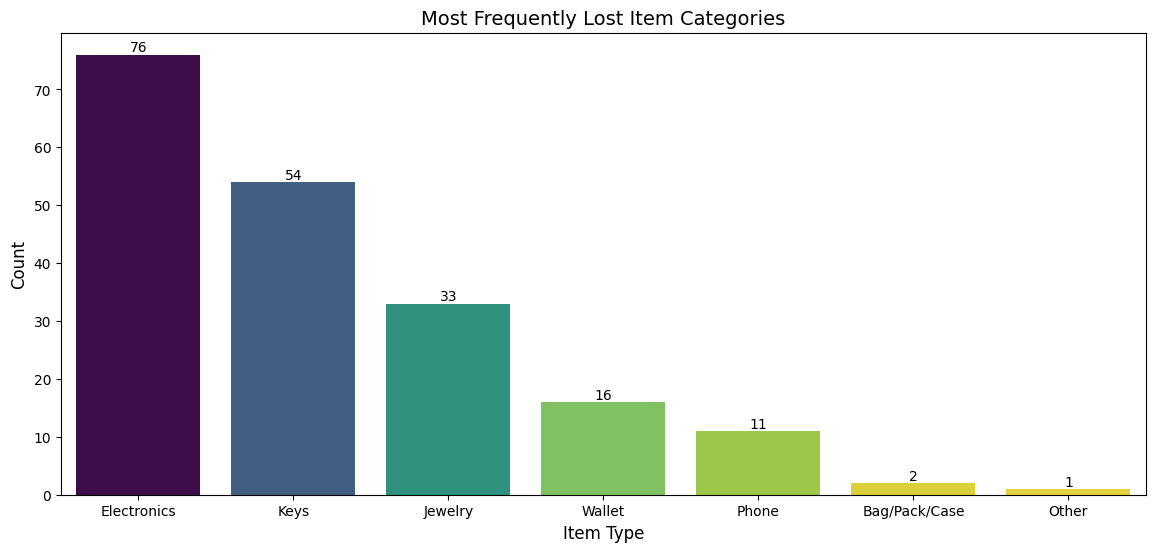

In [11]:
item_type_counts = df['Item Type'].value_counts()

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.barplot(x=item_type_counts.index, y=item_type_counts.values, palette='viridis_r', hue = item_type_counts.values, legend = False)
ax.set_xlabel("Item Type", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Most Frequently Lost Item Categories", fontsize = 14)

for i in ax.containers:
    ax.bar_label(i)
    
plt.show()

The bar plot above illustrates the distribution of lost items by type, highlighting the most frequently reported categories in the dataset. Electronics are the most commonly lost items, followed by keys and jewelry. Other categories, such as wallets and phones, are less frequent, while items classified as "Other" and bag/pack/case are rarely reported.

The analysis shows that certain item types, particularly electronics and keys, dominate the dataset. These findings suggest that targeted awareness campaigns or recovery strategies should focus on these high-frequency categories to maximize the effectiveness of lost and found services.

### Temporal Analysis

**Objective**: Examine seasonal and daily trends in lost item reports.

#### Monthly Trends

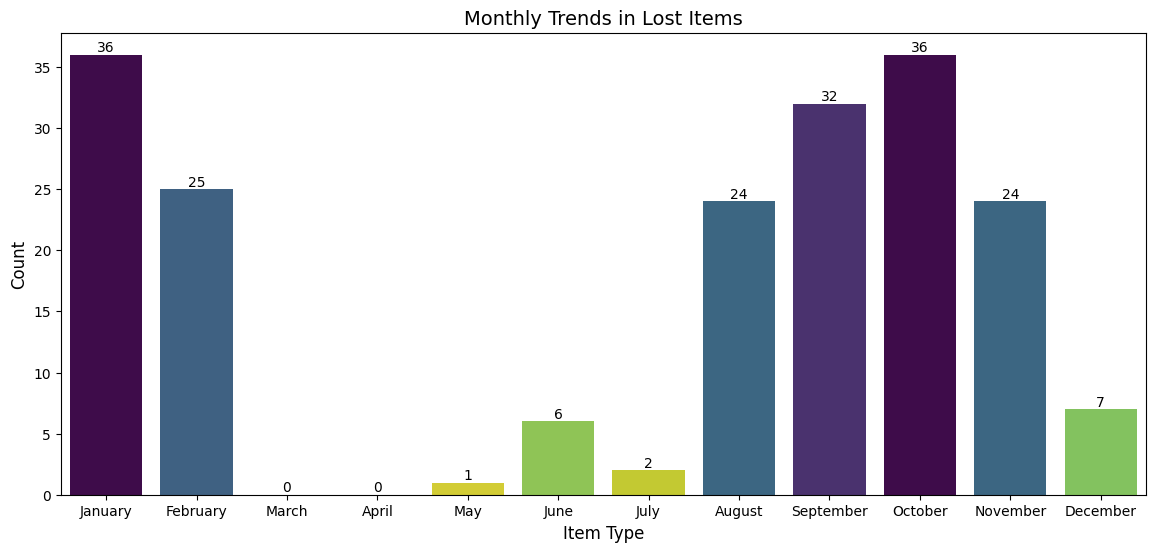

In [12]:
monthly_counts = df['Month'].value_counts().reindex(
    ["January", "February", "March", "April", "May", "June", 
     "July", "August", "September", "October", "November", "December"])
monthly_counts.fillna(0, inplace = True)

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='viridis_r', hue = monthly_counts.values, legend = False)
ax.set_xlabel("Item Type", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Monthly Trends in Lost Items", fontsize = 14)

for i in ax.containers:
    ax.bar_label(i)
    
plt.show()

The bar plot above highlights the number of lost items each month. Key observations include:
- October and January have the highest number of reports, followed closely by September
- There is a noticeable absence of data for February, March, and April, so no conclusions can be drawn about lost item trends during these months
- The months of May, June, and July show low to moderate activity, ranging from 1 to 6 lost items.

These monthly trends suggest that the frequency of lost items follow closely with the university's academic calendar. Peaks in lost items during September, October, and January may correspond to the start of the academic term, where student activity on campus is at its peak. Conversely, the low counts during the summer months suggest that there are fewer people on campus.

#### Weekday Trends Across Months

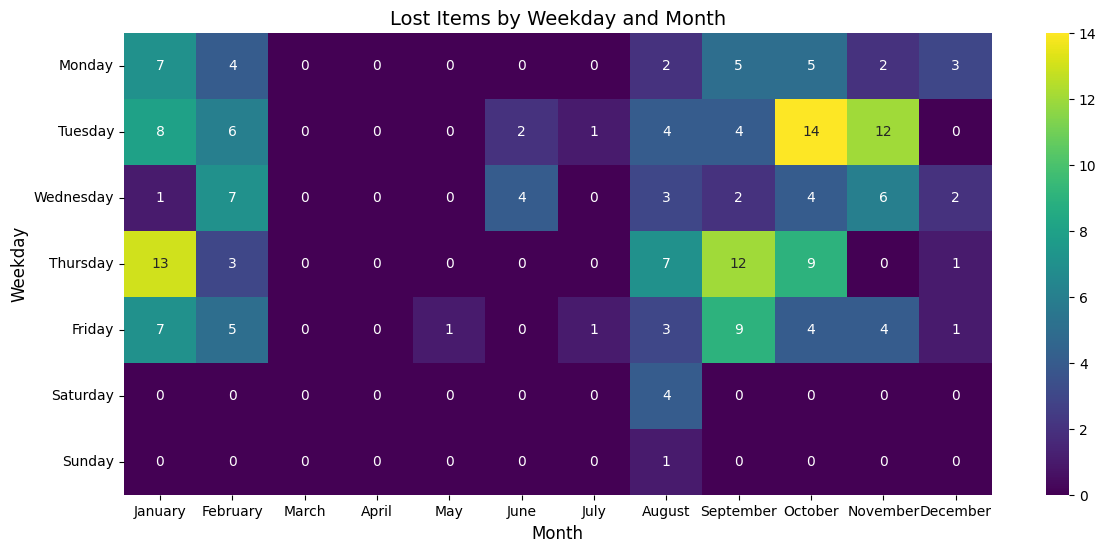

In [13]:
weekday_counts = pd.crosstab(df['Weekday'], df['Month'], margins = True)
weekday_counts = weekday_counts.reindex(index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", 
     "Sunday"], columns = ["January", "February", "March", "April", "May", "June", 
     "July", "August", "September", "October", "November", "December"])
weekday_counts.fillna(0, inplace = True)
weekday_counts = weekday_counts.astype("int")

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.heatmap(weekday_counts, cmap="viridis", annot=True, fmt='d')
ax.set_xlabel("Month", fontsize = 12)
ax.set_ylabel("Weekday", fontsize = 12)
ax.set_title("Lost Items by Weekday and Month", fontsize = 14)

plt.show()

The heatmap above provides a detailed breakdown of lost item reports by weekday and month. Key insights include:

- Tuesday consistently shows higher reports, especially during October and November, where it peaks at 14 and 12 lost items, respectively
- Monday, Thursday and Friday show moderate activity, particularly during August to October
- Weekend days (Saturday and Sunday) have significantly lower lost item reports, which reflects lower campus activity on these days

This shows that weekday trends also follow closely with the university's schedule, with the most reports during active weekdays and fewer during weekends or months when the campus is less busy.

### Location Analysis

**Objective**: Identify the most common campus locations where items are lost.

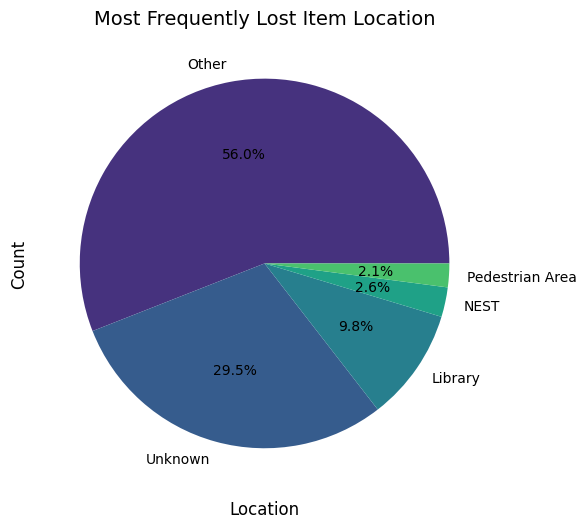

In [14]:
location_counts = df['Lost Item Location'].value_counts()
location_counts

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
color = sns.color_palette('viridis') 
ax.pie(x = location_counts.values, labels =location_counts.index, autopct = '%1.1f%%', colors = color)
ax.set_xlabel("Location", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Most Frequently Lost Item Location", fontsize = 14)

plt.show()

The pie chart illustrates the distribution of lost items across various campus locations:

- "Other" accounts for 56.0% of all reports. This category likely represents locations not explicitly listed or frequently visited but less defined spaces.
- "Unknown" makes up the second-largest segment. These entries highlight cases where the precise location of the lost item was not specified, emphasizing the need for more detailed reporting.
- Among the specified locations:
   - The Library recorded 9.8% of all reports, making it the most common explicitly named location for lost items likely to high traffic and prolonged usage by students.
   - The NEST and Pedestrian Area make up 2.6% and 2.1% of reports respectively, indicating relatively low activity compared to other categories.

### Item Description Analysis

**Objective**: To group similar items based on "Item Description" and identify detailed subcategories of lost items, we applied natural language processing (NLP) techniques. This analysis aims to extract meaningful features and uncover underlying themes to better understand the types of items frequently lost.


#### Preprocessing

In [15]:
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

def preprocess(
    doc
):
    clean_text = []

    for token in doc:
        if (
            token.is_stop == False 
            and token.is_punct == False
            and token.is_alpha == True
        ):
            lemma = token.lemma_
            clean_text.append(lemma.lower())
    return " ".join(clean_text)

df["Cleaned Item Description"] = [preprocess(text) for text in nlp.pipe(df["Item Description"])]

We used the `spaCy` library to preprocess the item descriptions. The preprocessing steps included:

1. Removing stop words: Eliminates common but uninformative words like "the" or "and."
2. Removing punctuation and non-alphabetic characters: Focused on meaningful textual data.
3. Lemmatization: Reduced words to their base forms (e.g., "keys" to "key") for better grouping.

The cleaned descriptions were stored in a new column, `Cleaned Item Description`

#### Topic Modeling

In [16]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), max_features=500, ngram_range=(1, 3))
document = vectorizer.fit_transform(df['Cleaned Item Description'])

n_topics = 7
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_decay = 0.8)
lda.fit(document)

document_topics = lda.transform(document)

We used Latent Dirichlet Allocation (LDA) for topic modeling. Key steps:

- Vectorization: CountVectorizer converted text into numerical format using unigrams, bigrams, and trigrams to capture context. A maximum of 500 features were extracted.
- LDA Model: The model identified 7 latent topics, with parameters tuned to optimize learning and topic diversity.

Here are the top 7 words associated with each topic:

In [17]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vectorizer.get_feature_names_out())

mglearn.tools.print_topics(
    topics=range(n_topics),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=4,
    n_words=7,
)

topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
wallet        watch         phone         ring          
air           airpod        air           fob           
pod           smart         auto          card          
air pod       smart watch   key           car           
card          case          case          car fob       
bracelet      wallet        head          black         
case          distinctive   tag           holder        


topic 4       topic 5       topic 6       
--------      --------      --------      
ear           headphone     key           
bud           ear           ring          
ear bud       case          single key    
key           digital       single        
ear bud case  ear headphone key ring      
bud case      apple         fob           
case          pen           lanyard       




The new topics could be interpreted as followed:

|Topic	|Top Words	|Interpretation|
| ---   | ----------|--------------|
|0	|key, ring, single key, fob, lanyard	|Keys and Accessories|
|1	|case, airpod, bracelet, air pods, phone	|Cases, AirPods and Phones|
|2	|ear, bud, ear bud case, headphone	|Headphones and Ear buds|
|3	|card, wallet, card holder, silver	|Wallets and Cards|
|4	|watch, smart, smart watch	|Watches|
|5	|car, fob, car key, car fob	|Car Keys|
|6	|digital, pen, pencil	|Digital tools & Stationary|

- **Topic 0 (Keys and Accessories)**: Keys and related accessories, such as rings and lanyards, are frequently lost. Personalized keychains or name tags could improve recovery
- **Topic 1 (Cases, AirPods and Phones)**: Phones and small tech accessories are commonly lost. This highlights the importance of tracking devices or softwares
- **Topic 2 (Headphones and Ear buds)**: Items like earbuds and headphones are often left behind, which suggests a need of preventive measures such as awareness campaigns
- **Topic 3 (Wallets and Cards)**: Valuables like wallets and cards are also commonly lost and require additional attention on campus to improve recovery rates
- **Topic 4 (Watches)**: Watches, particularly smartwatches, are significant loss items. Advanced recovery solutions may be necessary
- **Topic 5 (Car Keys)**: Car-related items like keys and fobs are small and can be easily lost, reinforcing the need for better awareness measures
- **Topic 6 (Digital tools & Stationary)**: Digital tools and writing stationary are often used in classrooms and may easily be left behind. They are a niche but noteworthy category

## Time Series Forecasting
---

In this section, we compare the effectiveness of two models, ARIMA and LSTM, in forecasting the number of lost and found items reported. The primary objective is to determine which model performs better at capturing the underlying patterns in the data for accurate forecasting.

- **ARIMA**: Designed for time series data with linear patterns and stationarity, ARIMA excels in modeling short-term trends and seasonality
- **LSTM**: A deep learning approach capable of capturing complex, non-linear dependencies and long-term temporal patterns in sequential data

### ARIMA model

#### Data Preparation

We first preprocess the dataset for ARIMA modeling:

In [18]:
# Group by date to get daily counts
item_counts = df.groupby('Date').size()

# Resample to daily and weekly frequency
time_series = {
    "daily": item_counts.resample('D').sum().fillna(0).to_frame(name='Count'),
    "weekly": item_counts.resample('W').sum().fillna(0).to_frame(name='Count'),
}

Two distinct time series are prepared for analysis. Daily aggregation helps capture day-to-day trends and variations in item reporting while weekly aggregation offers a higher-level view, capturing broader patterns while reducing noise from daily fluctuations.

Next, the time series are split into training and testing datasets:

In [19]:
# Train-test split for each time series
train_test_split = {}
for freq, series in time_series.items():
    train_size = int(len(series) * 0.8)
    train_test_split[freq] = {
        "train": series.iloc[:train_size],
         "test": series.iloc[train_size - 1:],
    }

for freq, data in train_test_split.items():
    print(f"{freq.capitalize()} Training data size: {len(data['train'])}")
    print(f"{freq.capitalize()} Testing data size: {len(data['test'])}")

Daily Training data size: 213
Daily Testing data size: 55
Weekly Training data size: 31
Weekly Testing data size: 9


Both series are split into 80% for training and 20% for testing to validate model performance on unseen data. To ensure a smooth transition between the training and testing data in the visualization, the last data point of the training set is included in the test set. This avoids any artificial gaps in the plot while maintaining continuity between the two sets.

#### Stationarity Check

For ARIMA to work effectively, the input time series must be stationary. This means its statistical properties (e.g., mean, variance) remain constant over time. We test for stationarity using the Augmented Dickey-Fuller (ADF) Test: 
- A p-value < 0.05 indicates the series is stationary.
- If the series is non-stationary (p-value ≥ 0.05), differencing is applied to make it stationary.

In [20]:
def check_stationarity(series, name):
    adf_result = adfuller(series)
    print(f"{name.capitalize()} ADF Statistic: {adf_result[0]}")
    print(f"{name.capitalize()} p-value: {adf_result[1]}")
    if adf_result[1] > 0.05:
        print(f"{name.capitalize()} series is not stationary. Applying differencing...")
        return series.diff().dropna()
    else:
        print(f"{name.capitalize()} series is stationary.")
        return series

# Check stationarity for each train set
for freq, data in train_test_split.items():
    train_test_split[freq]["train"] = check_stationarity(data["train"], freq)

Daily ADF Statistic: -3.556338787866506
Daily p-value: 0.006652738858024328
Daily series is stationary.
Weekly ADF Statistic: -3.076466429403601
Weekly p-value: 0.02834451174990515
Weekly series is stationary.


#### ARIMA Modeling

Using ARIMA with an order of (1, 1, 1), we train separate models for the daily and weekly time series:

In [21]:
def fit_arima_and_forecast(train, test, order, title=""):
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=len(test))

    # Plot results
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 6)
    ax.plot(train, label='Train', color='#203147')
    ax.plot(test, label='Test', color='#01ef63')
    ax.plot(test.index, forecast, label='Forecast', color='orange')
    ax.set_xlabel("Date", fontsize = 12)
    ax.set_ylabel("Count", fontsize = 12)
    ax.set_title(title, fontsize = 14)

    plt.legend()
    plt.show()
    return fitted_model

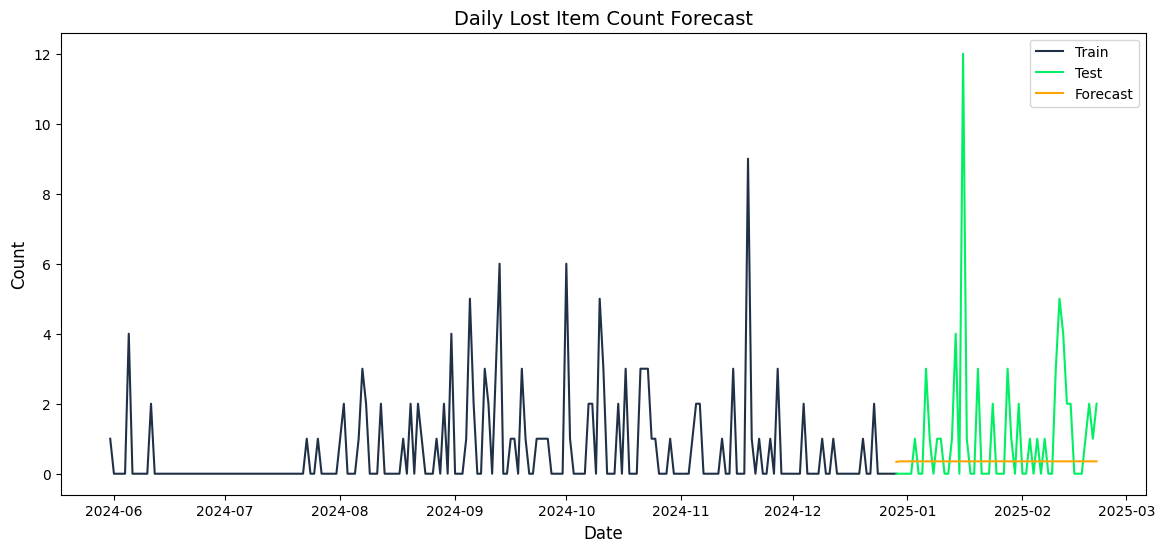

In [22]:
# Fit ARIMA on daily data
daily_forecast = fit_arima_and_forecast(
    train_test_split["daily"]["train"], 
    train_test_split["daily"]["test"], 
    order=(1, 1, 1), 
    title="Daily Lost Item Count Forecast"
)

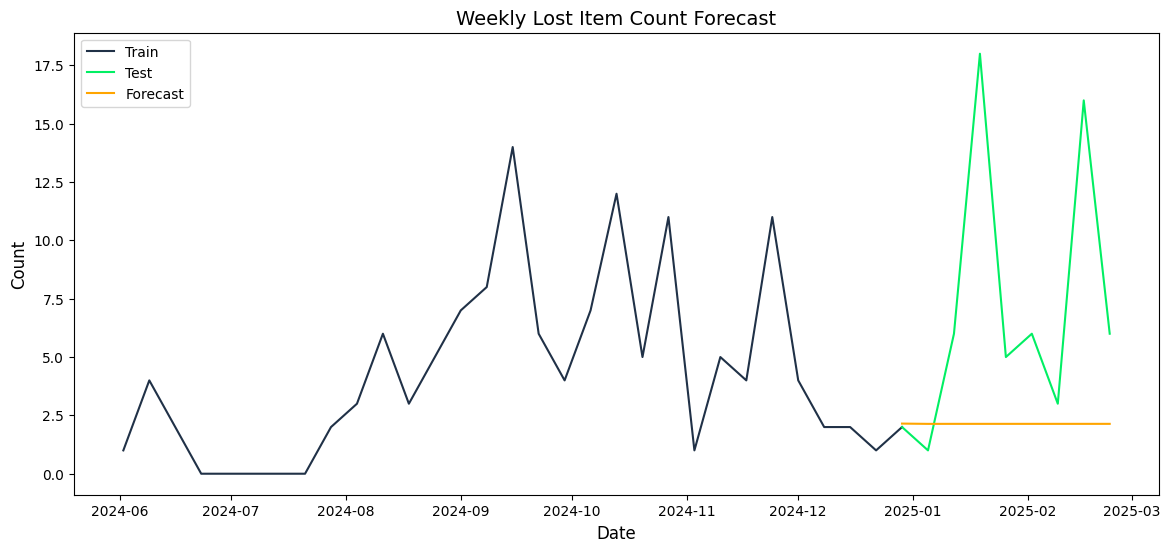

In [23]:
# Fit ARIMA on weekly data
weekly_forecast = fit_arima_and_forecast(
    train_test_split["weekly"]["train"], 
    train_test_split["weekly"]["test"], 
    order=(1, 1, 1), 
    title="Weekly Lost Item Count Forecast"
)

#### Model Diagnostics

We focus mainly on the following metrics to evaluate our models:

|Statistics|Description|
|---|---|
|Akaike Information Criterion (AIC) | Measures the relative quality of the model. Lower AIC values indicate a better-fitting model.|
|Bayesian Information Criterion (BIC)| Similar to AIC but penalizes model complexity more strongly. Lower BIC values indicate a better-fitting model.|
|Residuals| The differences between observed data points and the model's predictions. Ideally, residuals should follow a random "white noise" pattern (residuals with no discernible patterns, correlations, or structure), indicating the model has captured all underlying structure in the data.|
|Autoregressive (AR) | Measures how much the most recent past value influences the current value|
|Moving Average (MA) | Captures the effect of past forecast errors on the current value.|

##### 1. Daily Forecast Diagnostics

The ARIMA model for daily forecasts yields the following results:

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  213
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -349.838
Date:                Sat, 22 Feb 2025   AIC                            705.676
Time:                        15:27:58   BIC                            715.746
Sample:                    05-31-2024   HQIC                           709.746
                         - 12-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0423      0.085      0.499      0.618      -0.124       0.208
ma.L1         -0.9480      0.025    -38.550      0.000      -0.996      -0.900
sigma2         1.5715      0.061     25.892      0.0

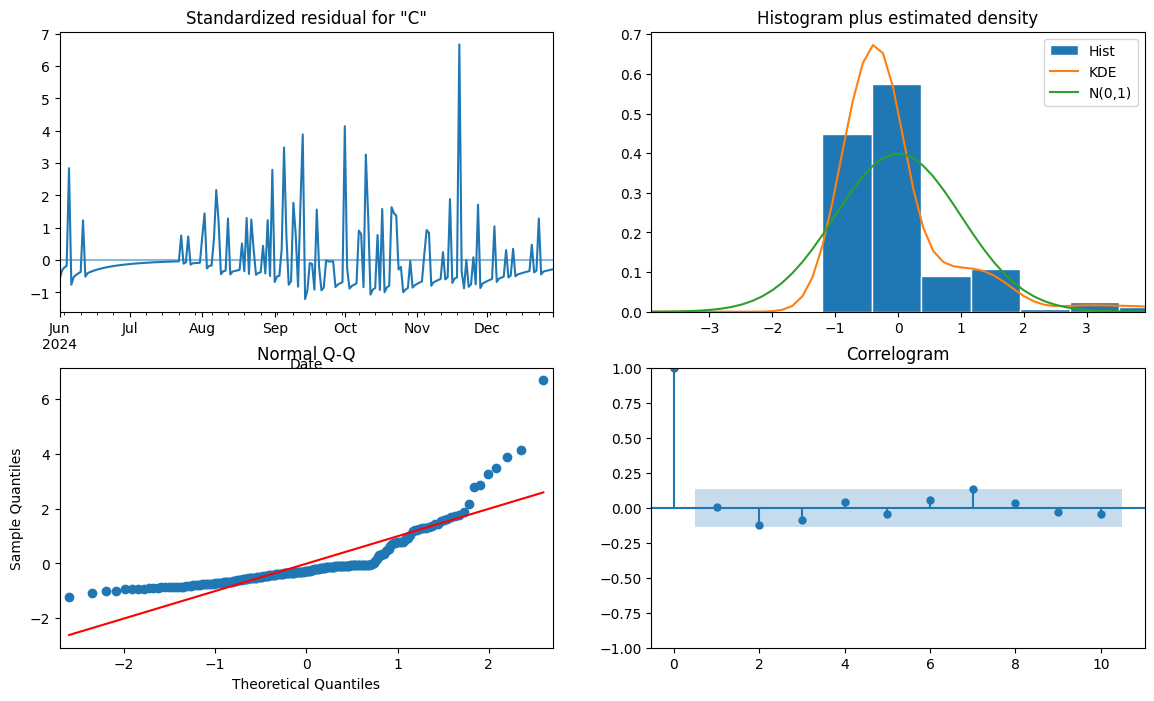

In [24]:
print(daily_forecast.summary())

daily_forecast.plot_diagnostics(figsize=(14, 8))
plt.show()

Key observations:

- The AIC (705.676) and BIC (715.746) are slightly high, which suggest there might be room to improve the model's fit by tuning hyperparameters.
- While the residuals appear to exhibit some characteristics of white noise, the slight skewness and heteroskedasticity (as indicated by the high Jarque-Bera and Heteroskedasticity test results) suggest the model may not fully capture the data dynamics.
- The AR has a p-value of 0.618 and is statistically insignificant (p > 0.05), which indicates that the AR component doesn't meaningfully contribute to the model's predictions
- The MA has a p-value of 0.000 and is statistically significant (p < 0.05), which implies that past errors contribute signficantly to current forecast.

##### 2. Weekly Forecast Diagnostics

The ARIMA model for weekly forecasts provides the following results:

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -79.382
Date:                Sat, 22 Feb 2025   AIC                            164.763
Time:                        15:27:59   BIC                            168.967
Sample:                    06-02-2024   HQIC                           166.108
                         - 12-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0813      0.291     -0.279      0.780      -0.651       0.489
ma.L1         -0.5560      0.238     -2.338      0.019      -1.022      -0.090
sigma2        11.4586      3.131      3.659      0.0

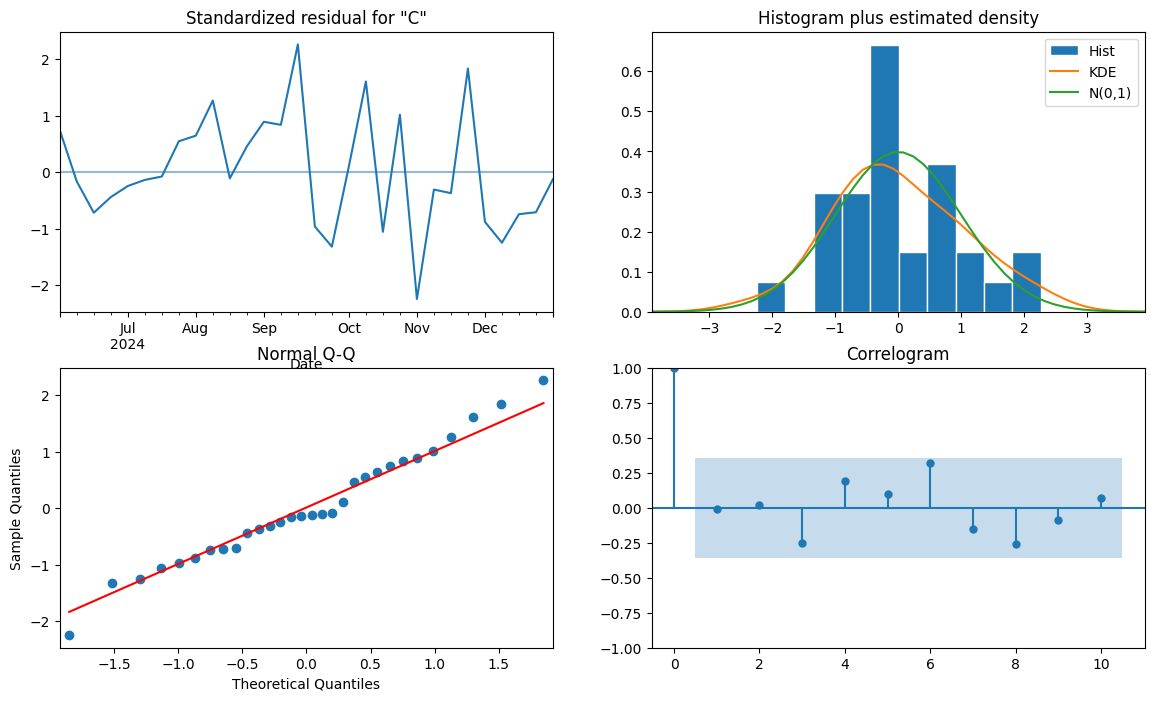

In [25]:
print(weekly_forecast.summary())

weekly_forecast.plot_diagnostics(figsize=(14, 8))
plt.show()

Key observations:

- The AIC (164.763) and BIC (168.967) are lower compared to the daily model, reflecting better relative fit. However, the small sample size (27 observations) may impact model stability and reliability.
- The residuals mostly exhibit characteristics of white noise, which suggests a reasonable fit. The skewness (0.13) and kurtosis (2.70) are also near normal levels, which aligns with assumptions of residual normality.
- The AR has a p-value of 0.780 and is statistically insignificant (p > 0.05), which indicates that the AR component doesn't meaningfully contribute to the model's predictions
- The MA has a p-value of 0.019 and is significant (p < 0.05), which implies that past errors contribute signficantly to current forecast.

#### Model Evaluation

We also use Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE) to measure forecast accuracy.

In [26]:
def evaluate_forecast(test, forecast, title):
    test = np.array(test)
    forecast = np.array(forecast)

    rmse = root_mean_squared_error(test, forecast)
    mape = np.mean(np.abs((test - forecast) / test)) * 100

    print(f"{title} Evaluation:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")

In [27]:
evaluate_forecast(
    train_test_split["daily"]["test"], 
    daily_forecast.forecast(steps=len(train_test_split["daily"]["test"])), 
    title="Daily Forecast"
)

Daily Forecast Evaluation:
  RMSE: 2.07
  MAPE: inf%


C:\Users\jshum\AppData\Local\Temp\ipykernel_68464\4160145908.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((test - forecast) / test)) * 100


A RMSE of 2.07 indicates that, on average, the model's daily predictions deviate by approximately 2.07 units from actual count of lost items. MAPE is not interpretable due to division by zero in some test values.

In [28]:
evaluate_forecast(
    train_test_split["weekly"]["test"], 
    weekly_forecast.forecast(steps=len(train_test_split["weekly"]["test"])), 
    title="Weekly Forecast"
)

Weekly Forecast Evaluation:
  RMSE: 7.44
  MAPE: 63.84%


A RMSE of 7.44 shows greater deviation from actual weekly values. This reflects the model's difficulty in capturing broader weekly patterns compared to the daily predictions. A MAPE of 63.84% is also quite high, which signifies poor reliability for percentage-based errors, likely influenced by the limited data.

#### Results and Limitations

##### Evaluation Results
- The daily ARIMA model achieves better accuracy metrics (RMSE), but its AIC/BIC values and residual diagnostics suggest further optimization is needed.
- The weekly ARIMA model shows better residual stability but higher error metrics, highlighting challenges in capturing broader patterns due to limited data.

Future improvements for the models may include:

- Daily Model Improvements:
   - Fine-tune hyperparameters to improve AIC/BIC values.
   - Address heteroskedasticity and residual skewness, potentially by transforming the data or adding seasonal components.
     
- Weekly Model Improvements:
   - Increase data size for more stable parameter estimation.
   - Explore alternative models such as exponential smoothing or other machine learning approaches to better capture long-term trends.

##### Linear Nature of ARIMA
The ARIMA model assumes that the underlying relationships in the data can be adequately described by linear dependencies. While this works well for datasets with linear trends and simple seasonality, it has limitations when applied to:

- Nonlinear Data Patterns: Complex interactions or nonlinear relationships cannot be effectively captured by ARIMA.
- Changing Dynamics: Sudden changes, long-term nonlinear trends, or interactions across multiple factors are beyond ARIMA's scope.

##### Observations in Forecast Plots
The forecast plot for the ARIMA model shows a nearly linear trend for predictions, which fails to capture the variability and curvature seen in the test data. The model oversimplifies the dynamics, leading to forecasts that lack nuance and fail to track actual patterns in the test data. Consequently, this mismatch suggests that the model may not be adequately representing the underlying structure of the dataset.

##### Recommendation
While ARIMA offers a solid baseline for time series forecasting, its linear assumptions limit its ability to fully capture the nuances of the dataset, as shown by the mismatch in forecast plots and evaluation metrics. To overcome these challenges and improve predictive performance, we propose transitioning to LSTM models, which are designed to capture complex, nonlinear relationships and long-term dependencies.


### LSTM Model

#### Data Preparation

To train an LSTM model, we need to prepare input-output pairs and structure the data in a format suitable for the LSTM model.

##### Step 1: Normalize the Data

We first normalize the Count column of the training and testing sets to scale values between [0, 1] using MinMaxScaler.

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))

for freq in train_test_split.keys():
    train_scaled = train_test_split[freq]['train'].copy()
    test_scaled = train_test_split[freq]['test'].copy()
    
    train_scaled_features = scaler.fit_transform(train_test_split[freq]['train']['Count'].values.reshape(-1, 1))
    test_scaled_features = scaler.transform(train_test_split[freq]['test']['Count'].values.reshape(-1, 1))

    train_test_split[freq]['train_scaled'] = pd.DataFrame(
        train_scaled_features, index=train_scaled.index, columns=['Count']
    )
    train_test_split[freq]['test_scaled'] = pd.DataFrame(
        test_scaled_features, index=test_scaled.index, columns=['Count']
    )

##### Step 2: Feature engineering

Next, we create feature engineered features as additional inputs to the model. For the daily model, we include day of the week and a binary feature indicating whether the day is weekend as extra features. Since LSTMs handle numerical data, we one-hot encode the features. For the weekly model, a month feature and lagged features are added to provide past context for each time step. These features allow the model to learn patterns over time by including data from previous weeks as additional input features.

In [30]:
# Day of the week feature
day_encoder = OneHotEncoder(sparse_output=False)

train_test_split['daily']['train_scaled']['Day of Week'] = train_test_split['daily']['train_scaled'].index.dayofweek
train_test_split['daily']['test_scaled']['Day of Week'] = train_test_split['daily']['test_scaled'].index.dayofweek

train_days_encoded = day_encoder.fit_transform(train_test_split['daily']['train_scaled'][['Day of Week']])
test_days_encoded = day_encoder.transform(train_test_split['daily']['test_scaled'][['Day of Week']])

day_columns = [f"day_{i}" for i in range(train_days_encoded.shape[1])]
train_test_split['daily']['train_scaled'][day_columns] = train_days_encoded
train_test_split['daily']['test_scaled'][day_columns] = test_days_encoded

train_test_split['daily']['train_scaled'].drop(columns=['Day of Week'], inplace=True)
train_test_split['daily']['test_scaled'].drop(columns=['Day of Week'], inplace=True)

In [31]:
# Weekend feature
weekend_encoder = OneHotEncoder(sparse_output=False, drop='if_binary')

train_test_split['daily']['train_scaled']['Weekend'] = train_test_split['daily']['train_scaled'].index.weekday >= 5
train_test_split['daily']['test_scaled']['Weekend'] = train_test_split['daily']['test_scaled'].index.weekday >= 5

train_test_split['daily']['train_scaled']['Weekend'] = weekend_encoder.fit_transform(train_test_split['daily']['train_scaled'][['Weekend']])
train_test_split['daily']['test_scaled']['Weekend'] = weekend_encoder.transform(train_test_split['daily']['test_scaled'][['Weekend']])

In [32]:
# Month feature
month_encoder = OneHotEncoder(sparse_output=False, handle_unknown = "ignore")

train_test_split['weekly']['train_scaled']['Month'] = train_test_split['weekly']['train_scaled'].index.month
train_test_split['weekly']['test_scaled']['Month'] = train_test_split['weekly']['test_scaled'].index.month

train_days_encoded = month_encoder.fit_transform(train_test_split['weekly']['train_scaled'][['Month']])
test_days_encoded = month_encoder.transform(train_test_split['weekly']['test_scaled'][['Month']])

month_columns = [f"month_{i}" for i in range(train_days_encoded.shape[1])]
train_test_split['weekly']['train_scaled'][month_columns] = train_days_encoded
train_test_split['weekly']['test_scaled'][month_columns] = test_days_encoded

train_test_split['weekly']['train_scaled'].drop(columns=['Month'], inplace=True)
train_test_split['weekly']['test_scaled'].drop(columns=['Month'], inplace=True)

In [33]:
# Lag features
for lag in range(1, 3):
    train_test_split['weekly']['train_scaled'][f'Count_lag{lag}'] = (
        train_test_split['weekly']['train_scaled']['Count'].shift(lag)
    )
    train_test_split['weekly']['test_scaled'][f'Count_lag{lag}'] = (
        train_test_split['weekly']['test_scaled']['Count'].shift(lag)
    )

train_test_split['weekly']['train_scaled'].dropna(inplace=True)
train_test_split['weekly']['test_scaled'].dropna(inplace=True)

##### Step 3: Create Input-Output Sequences

For LSTMs, we need overlapping sequences of a specified length as input, with the target value being the value immediately following each sequence. We define a `create_sequences` function to generate sequences and their corresponding target values.

In [34]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].values
        target = data.iloc[i + sequence_length]['Count']
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(np.array(sequences), dtype = torch.float32), torch.tensor(np.array(targets), dtype = torch.float32)

In [35]:
# Generate sequences for daily and weekly data
sequence_length_daily = 7
sequence_length_weekly = 2
X_train_daily, y_train_daily = create_sequences(train_test_split['daily']['train_scaled'], sequence_length_daily)
X_test_daily, y_test_daily = create_sequences(train_test_split['daily']['test_scaled'], sequence_length_daily)

X_train_weekly, y_train_weekly = create_sequences(train_test_split['weekly']['train_scaled'], sequence_length_weekly)
X_test_weekly, y_test_weekly = create_sequences(train_test_split['weekly']['test_scaled'], sequence_length_weekly)

In [36]:
import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the encoders
joblib.dump(day_encoder, 'day_encoder.pkl')
joblib.dump(weekend_encoder, 'weekend_encoder.pkl')
joblib.dump(month_encoder, 'month_encoder.pkl')

['month_encoder.pkl']

#### LSTM Modelling 

In this step, we define an LSTM model using PyTorch. The model consists of the following components:

- LSTM Layer: Learns temporal dependencies from the input sequences.
- Fully Connected (FC) Layer: Maps the output from the LSTM to the final prediction.

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

We initialize the model, loss function, and optimizer as follows:
- Model: An instance of LSTMModel with specificed hyperparameters
- Loss Function: Mean Squared Error (MSE) is used to measure the difference between predictions and targets.
- Optimizer: Adam optimizer is chosen for its efficiency in training deep learning models.

In [38]:
# Initialize model, loss, and optimizer
torch.manual_seed(0)
input_size_daily = train_test_split['daily']['train_scaled'].shape[1]
input_size_weekly = train_test_split['weekly']['train_scaled'].shape[1]
hidden_size = 100
num_layers = 1
output_size = 1

model_daily = LSTMModel(input_size_daily, hidden_size, num_layers, output_size)
criterion_daily = nn.MSELoss()
optimizer_daily = torch.optim.Adam(model_daily.parameters(), lr=0.001)

model_weekly = LSTMModel(input_size_weekly, hidden_size, num_layers, output_size)
criterion_weekly = nn.MSELoss()
optimizer_weekly = torch.optim.Adam(model_weekly.parameters(), lr=0.001)

#### Training the Model

##### 1. Daily Forecast Model

In [39]:
num_epochs = 50
daily_loss = []

for epoch in range(num_epochs):
    model_daily.train()
    optimizer_daily.zero_grad()
    
    # Forward pass
    outputs = model_daily(X_train_daily)
    loss = criterion_daily(outputs, y_train_daily.view(-1, 1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer_daily.step()

    daily_loss.append(loss.item())
    
    # Log the training progress
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0198
Epoch 2/50, Loss: 0.0196
Epoch 3/50, Loss: 0.0194
Epoch 4/50, Loss: 0.0192
Epoch 5/50, Loss: 0.0190
Epoch 6/50, Loss: 0.0188
Epoch 7/50, Loss: 0.0187
Epoch 8/50, Loss: 0.0186
Epoch 9/50, Loss: 0.0184
Epoch 10/50, Loss: 0.0183
Epoch 11/50, Loss: 0.0182
Epoch 12/50, Loss: 0.0181
Epoch 13/50, Loss: 0.0180
Epoch 14/50, Loss: 0.0180
Epoch 15/50, Loss: 0.0179
Epoch 16/50, Loss: 0.0179
Epoch 17/50, Loss: 0.0178
Epoch 18/50, Loss: 0.0178
Epoch 19/50, Loss: 0.0177
Epoch 20/50, Loss: 0.0177
Epoch 21/50, Loss: 0.0177
Epoch 22/50, Loss: 0.0176
Epoch 23/50, Loss: 0.0176
Epoch 24/50, Loss: 0.0176
Epoch 25/50, Loss: 0.0175
Epoch 26/50, Loss: 0.0175
Epoch 27/50, Loss: 0.0175
Epoch 28/50, Loss: 0.0175
Epoch 29/50, Loss: 0.0174
Epoch 30/50, Loss: 0.0174
Epoch 31/50, Loss: 0.0174
Epoch 32/50, Loss: 0.0174
Epoch 33/50, Loss: 0.0173
Epoch 34/50, Loss: 0.0173
Epoch 35/50, Loss: 0.0173
Epoch 36/50, Loss: 0.0173
Epoch 37/50, Loss: 0.0173
Epoch 38/50, Loss: 0.0173
Epoch 39/50, Loss: 0.

In [40]:
# Save the model state
torch.save(model_daily.state_dict(), 'lstm_daily_model.pth')

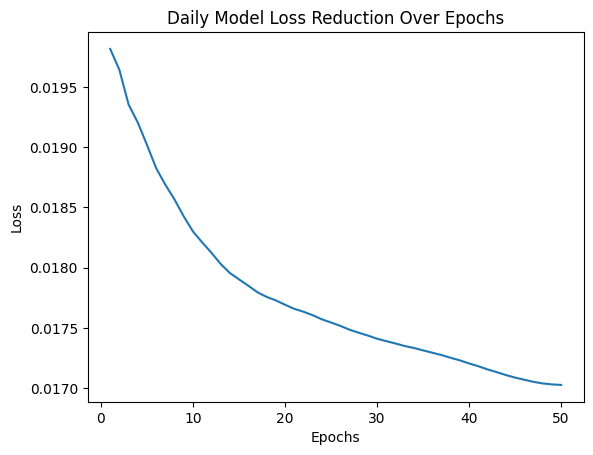

In [41]:
epochs = range(1, 51)

plt.plot(epochs, daily_loss, label='Daily Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Daily Model Loss Reduction Over Epochs')
plt.show()

The training loss for the daily LSTM model decreases steadily over the 50 epochs, starting at 0.0198 and converging to 0.0170. This consistent decline in loss indicates that the model is learning to minimize the prediction error effectively over time. The relatively low initial loss suggests that the daily model starts with a reasonable approximation of the data.

##### 2. Weekly Forecast Model

In [42]:
num_epochs = 50
weekly_loss = []

for epoch in range(num_epochs):
    model_weekly.train()
    optimizer_weekly.zero_grad()
    
    # Forward pass
    outputs = model_weekly(X_train_weekly)
    loss = criterion_weekly(outputs, y_train_weekly.view(-1, 1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer_weekly.step()

    weekly_loss.append(loss.item())
    
    # Log the training progress
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.2092
Epoch 2/50, Loss: 0.1990
Epoch 3/50, Loss: 0.1893
Epoch 4/50, Loss: 0.1798
Epoch 5/50, Loss: 0.1707
Epoch 6/50, Loss: 0.1618
Epoch 7/50, Loss: 0.1532
Epoch 8/50, Loss: 0.1449
Epoch 9/50, Loss: 0.1368
Epoch 10/50, Loss: 0.1289
Epoch 11/50, Loss: 0.1212
Epoch 12/50, Loss: 0.1139
Epoch 13/50, Loss: 0.1068
Epoch 14/50, Loss: 0.0999
Epoch 15/50, Loss: 0.0934
Epoch 16/50, Loss: 0.0872
Epoch 17/50, Loss: 0.0815
Epoch 18/50, Loss: 0.0761
Epoch 19/50, Loss: 0.0713
Epoch 20/50, Loss: 0.0669
Epoch 21/50, Loss: 0.0632
Epoch 22/50, Loss: 0.0600
Epoch 23/50, Loss: 0.0575
Epoch 24/50, Loss: 0.0557
Epoch 25/50, Loss: 0.0544
Epoch 26/50, Loss: 0.0538
Epoch 27/50, Loss: 0.0535
Epoch 28/50, Loss: 0.0537
Epoch 29/50, Loss: 0.0540
Epoch 30/50, Loss: 0.0542
Epoch 31/50, Loss: 0.0544
Epoch 32/50, Loss: 0.0543
Epoch 33/50, Loss: 0.0539
Epoch 34/50, Loss: 0.0533
Epoch 35/50, Loss: 0.0524
Epoch 36/50, Loss: 0.0513
Epoch 37/50, Loss: 0.0502
Epoch 38/50, Loss: 0.0491
Epoch 39/50, Loss: 0.

In [43]:
# Save the model state
torch.save(model_weekly.state_dict(), 'lstm_weekly_model.pth')

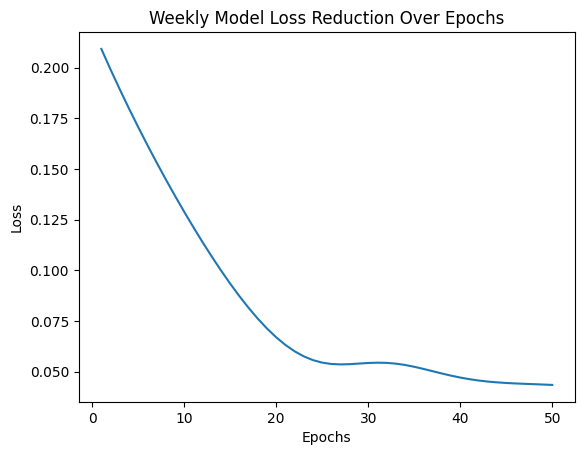

In [44]:
epochs = range(1, 51)

plt.plot(epochs, weekly_loss, label='Weekly Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Weekly Model Loss Reduction Over Epochs')
plt.show()

The training loss for the weekly LSTM model starts significantly higher at 0.2092 and drops to 0.0434 over 50 epochs. While the loss decreases substantially, the training curve is steeper in the initial epochs and flattens out as the model approaches convergence. The higher initial loss indicates that the weekly model struggles more to fit the data at the start of training. This is expected due to the longer-term dependencies in weekly data, which are harder to model with a single-layer LSTM.

#### Model Evaluation

After training, we evaluate the model's performance by comparing its predictions on the test set against the true values. The model predicts the next time step based on the input sequence, and the results are visualized to assess accuracy. The plots below compare the model's predictions (dashed line) with the original data (solid line) over time. This visualization helps assess how closely the model's predictions align with the actual data.

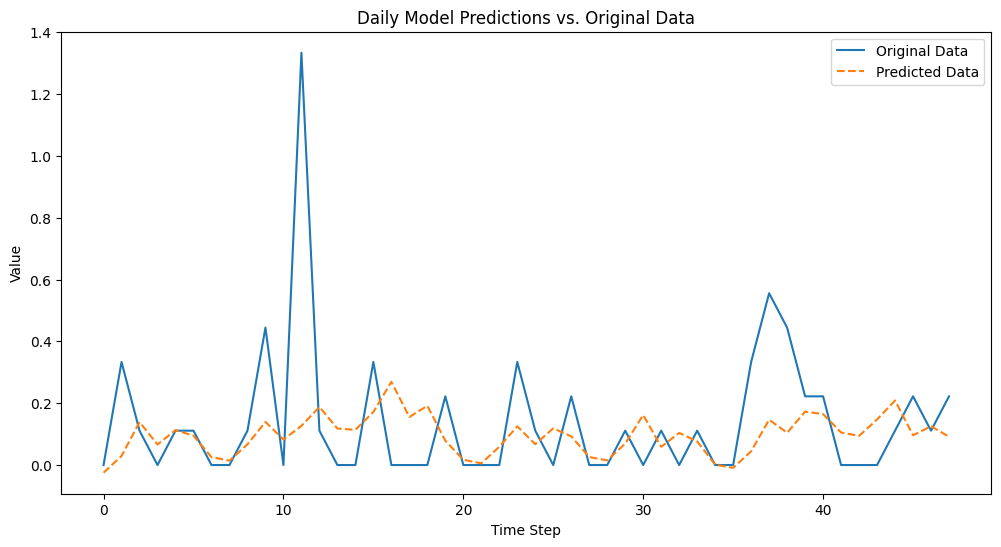

In [45]:
# Predicted outputs
model_daily.eval()
with torch.no_grad():
    predicted = model_daily(X_test_daily)

# Prepare original data and time steps for plotting
original = train_test_split['daily']['test_scaled']['Count'].iloc[sequence_length_daily:].values
time_steps = np.arange(len(original))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='--')
plt.title('Daily Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

From the daily model prediction plot, we see that the predicted values follow the actual trend fairly, which means the model is adequate at capturing short-term patterns.

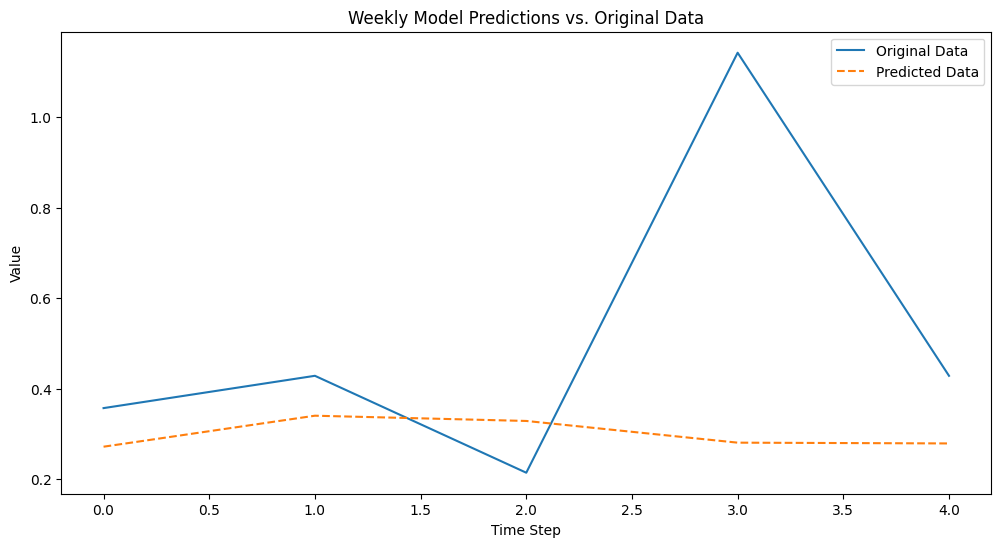

In [46]:
# Predicted outputs
model_weekly.eval()
with torch.no_grad():
    predicted = model_weekly(X_test_weekly)

# Prepare original data and time steps for plotting
original = train_test_split['weekly']['test_scaled']['Count'].iloc[sequence_length_weekly:].values
time_steps = np.arange(len(original))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='--')
plt.title('Weekly Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

From the weekly model prediction plot, we see that the predicted values do not quite follow the actual trend. Larger deviations could mean the model struggles with long-term dependencies. Including more features or training data may be needed to improve the model.

#### Results and Limitations

##### Evaluation Results

The LSTM model performs better on daily data compared to weekly data, as indicated by lower MSE loss values. This suggests that the model is more effective at capturing short-term temporal patterns. The daily model's better performance indicates its suitability for predicting daily usage trends, which can support better and more timely resource allocation. However, the weekly model struggles to capture long-term dependencies, resulting in higher MSE loss values and less reliable forecasts.

Future improvements for the models may include:

- Daily Model Improvements:

   - Incorporate trend features such as rolling averages over short-term (7-day) and long-term (30-day) windows.
   - Include contextual features, such as events, holidays, or weather data, to better account for external factors influencing the data.

- Weekly Model Improvements:

   - Expand the dataset to include more training data, which could help the model learn long-term dependencies more effectively.
   - Experiment with increasing the number of LSTM layers (num_layers) or units in the hidden state (hidden_size) to enhance the model's capacity for learning complex temporal patterns.

##### Limitations

While the LSTM model effectively captures nonlinear relationships in the dataset, it faces the following limitations:

- Limited Features: The current feature set focuses primarily on temporal aspects (e.g., day of the week, month). Incorporating additional contextual features, such as external events or categorical factors, could improve model performance.

- Dataset Size and Model Complexity: The small dataset size may cause the model to overfit, memorizing specific patterns instead of generalizing effectively. The single-layer LSTM architecture used for this study may also lack the capacity to model more intricate patterns, particularly in the weekly data.

##### Observations in Forecast Plots

The daily LSTM model's forecast plot shows better alignment with the actual data, successfully capturing variability and patterns that the ARIMA model missed. This demonstrates its ability to handle nonlinear trends and short-term dependencies.

However, the weekly LSTM model's predictions appear flatter and less responsive to changes in the data, suggesting a struggle to learn long-term dependencies. This limitation is likely due to the small dataset size and the simpler architecture used.

##### Recommendation
The daily LSTM model presents a significant improvement over ARIMA for short-term time series forecasting, thanks to its ability to model complex, nonlinear relationships. However, the weekly model's performance is held back by the dataset's small size and the model's limited complexity.

To improve the weekly model's predictive ability and overall reliability, future work should prioritize increasing the dataset size and incorporating additional features. For both daily and weekly models, further experimentation with hyperparameter tuning or more complex architectures, such as multi-layer LSTMs or hybrid models, could help achieve better results.



## Conclusion
--- 

### Key Findings

To summarize our findings from the exploratory data analysis:

#### 1. Item Classification and Trends

- Electronics and keys are the most frequently lost items, indicating a need for specialized storage solutions and awareness campaigns targeting these categories.

#### 2. Temporal Patterns
- Weekday Patterns:
  - Peak loss activity often occurred on Tuesdays. Mondays, Thursdays, and Fridays also showed moderate activity, while weekends consistently had fewer reports. This aligns with the traffic and activity on campus across the different days of the week.
- Monthly Patterns:
   - Losses were higher during specific times of the year where there are the most campus activity, such as the start of the school academic terms and midterms (fall and winter) while summer months showed minimal activity. These insights can help tailor staffing and resource planning for peak times.

#### 3. Location Analysis
- The "Other" category highlights undefined or underreported locations, suggesting the need for more detailed location reporting in the system.
- The Library, as a high-traffic area, requires targeted awareness campaigns and efficient storage solutions.

#### 4. Item Description Analysis
By applying natural language processing (NLP), we categorized item descriptions into the following topics, uncovering subcategories of lost items:

- Keys and Accessories: Frequently lost; personalized keychains or tags could aid recovery.
- Cases, AirPods, and Phones: Commonly misplaced tech items highlight the need for tracking devices or software solutions.
- Headphones and Earbuds: Preventive measures, like awareness campaigns, may reduce losses.
- Wallets and Cards: Valuables that require focused recovery efforts.
- Watches: Particularly smartwatches; advanced recovery solutions like GPS tracking may help.
- Car Keys: Small and easily misplaced; awareness measures can assist.
Digital Tools & Stationery: Frequently used in classrooms and prone to being left behind, these items form a niche but noteworthy category.

These findings provide important insights into loss item trends such as item categories distribution and temporal patterns, which will allow for better resource planning, improved recovery system, and targeted awareness campaigns. The collective findings serve as the foundation for improving the efficiency and effectiveness of the lost and found system.

### Model Comparison

The ARIMA and LSTM models offer distinct approaches to time series forecasting, each with strengths suited for different scenarios. This comparison shows both models' capabilities and the implications for resource planning in the lost and found system:

**ARIMA**

- Strengths:
   - ARIMA excels in modeling linear, stationary time series data with clear trends or seasonality. Its simplicity and interpretability make it useful for gaining quick insights into the overall structure of the data.
- Limitations:
  - Struggles with capturing nonlinear relationships and short-term variability
- Implications:
   - ARIMA’s inability to model nonlinear relationships makes it less effective for the dynamic, day-to-day variability of lost item activity. For tasks requiring long-term planning and aggregate trend analysis, ARIMA provides a dependable, low-complexity option.

**LSTM**

- Strengths:
   - The LSTM model's ability to capture nonlinear relationships and short-term dependencies makes it the better choice for daily forecasts. It can learn patterns that follow fairly with actual daily trends, enabling more responsive and accurate predictions.
- Limitations:
   - Weekly forecasting is less reliable due to limited data size and simpler architecture, highlighting the challenge of learning long-term dependencies.
- Implications:
   - The LSTM's moderate performance in daily forecasts suggests it is suited for day-to-day resource planning. By providing actionable insights into short-term fluctuations in lost and found activity, it allows for better preparation, such as adjusting staffing or storage allocation. However, its less reliable performance in weekly forecasting, due to data and model limitations, highlights the need for further improvements when addressing long-term trends.
 
In summary, the comparison shows a trade-off between simplicity and predictive power. ARIMA’s straightforward nature makes it a solid choice for exploratory analysis and linear trends, but it lacks the flexibility needed for complex, real-world patterns. LSTM, while more powerful for nonlinear relationships, requires sufficient data and hyperparameter tuning to fully utilize its capabilities. By combining the insights from both models, we can develop a more robust forecasting strategy that balances short-term adaptability with long-term planning reliability. 

### Actionable Recommendations

Based on our findings and model outputs, the following recommendations are established as a foundation for potential improvements to the lost and found system in hopes to bridge the gap between data-driven predictions and practical implementation. 

1. Targeted Awareness Campaigns:
   - Design targeted awareness campaigns and initiatives, such as setting up posters to remind students to be more careful of their belongings in high-traffic areas like the library or during high-risk periods like midterms
   - Use social media or university-wide communication channels to share tips for securing belongings

2. Optimized Item Storage:
   - Allocate storage resources based on forecasted item trends, ensuring space is optimized for commonly lost categories like electronics and keys
   - Implement digital inventory systems to streamline item tracking and retrieval.

3. Enhanced Communication Channels:
   - Develop a centralized mobile or web platform for real-time reporting and updates on found items.
   - Encourage detailed reporting by requiring users to specify item locations and descriptions.

### Future Directions

To further improve forecasting and extend the system's applications, we propose the following future enhancements:

Expanding dataset size:

- Data gaps like missing months and a lack of contextual features like weather or campus events have limited the scope of some analyses. Data should be collected over a longer period to improve forecasting accuracy and analyze trends in greater detail

Refining Models:

- Experiment with hybrid models, such as combining ARIMA and LSTM, to utilize both linear and nonlinear trend-capturing abilities
- Explore advanced architectures like attention mechanisms to improve weekly forecasting reliability

Extending Use Cases:

- Adapt the system to predict item recovery times or identify the likelihood of certain items being claimed
- Broaden the application to similar domains, such as lost and found systems for city transit or events


### Final Reflection

This project demonstrates how data-driven approaches can extract meaningful insights from operational systems like the lost and found process and transform them into actionable strategies that enhance efficiency and proactivity. By identifying key trends and leveraging predictive models, we developed practical recommendations to optimize resource allocation, improve item management systems, and strengthen communication channels.

Beyond this specific application, the findings highlight the transformative potential of applying similar methodologies to other domains. These strategies can support the creation of scalable, impactful systems that integrate technology into solving everyday challenges.  By refining and expanding this work, the lost and found system can become a vital resource for the UBC community, fostering a more organized, accessible, and responsive campus environment.